# ECONOMETRICS VS MACHINE LEARNING: A TIME SERIES CHALLENGE

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [2]:
data = pd.read_csv('data/IBM_adjusted.txt', sep=",", header=None)
data.columns = ['Date','Time','Open', 'High', 'Low', 'Close', 'Volume']
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True)
mask = (data.Time >= '09:30') & (data.Time <= '16:00')
df = data[mask]
df['log_vol'] = np.log(1.0 + df['Volume'])
df.shape[0]

c:\users\vilieri.i\onedri~1\tikit\my_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2144978

In [3]:
df.head()

,Date,Time,Open,High,Low,Close,Volume,log_vol
0,1998-01-02,09:30,33.69,33.69,33.69,33.69,207820,12.244432
1,1998-01-02,09:31,33.65,33.69,33.65,33.65,33499,10.419301
2,1998-01-02,09:32,33.67,33.69,33.65,33.69,41254,10.627528
3,1998-01-02,09:33,33.67,33.69,33.65,33.65,52110,10.861131
4,1998-01-02,09:34,33.65,33.69,33.65,33.65,14892,9.608647


In [4]:
print(df.shape[0])
print(df.dtypes)
print(df.Date.min())
print(df.Date.max())

2144978
Date       datetime64[ns]
Time               object
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
log_vol           float64
dtype: object
1998-01-02 00:00:00
2019-12-12 00:00:00


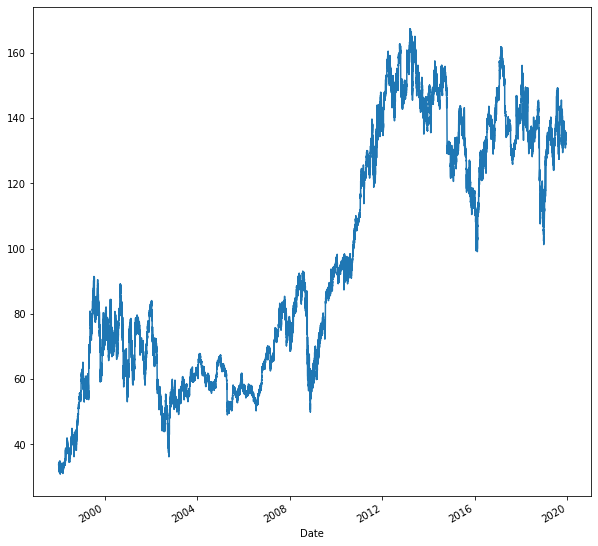

In [5]:
# Let's plot the whole serie
df.set_index(['Date'])['Open'].plot(figsize=(10,10))

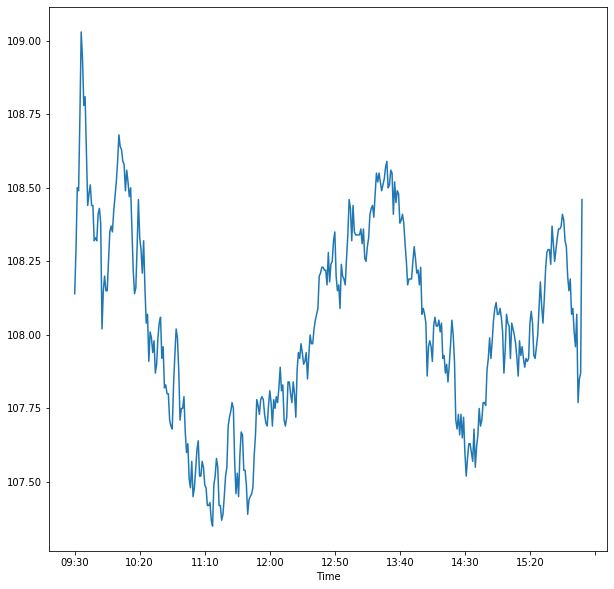

In [6]:
day1 = df[df['Date']=='12/31/2018']
day1.set_index(['Time'])['Open'].plot(figsize=(10,10))

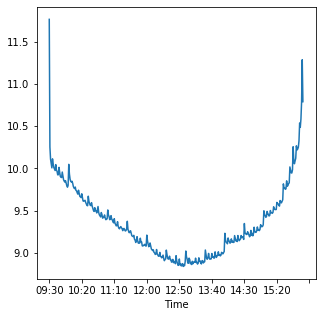

In [7]:
minutes = df.groupby('Time').mean().reset_index()
minutes.set_index(['Time'])['log_vol'].plot(figsize=(5,5))

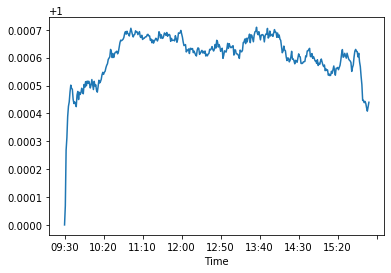

In [8]:
date_opens = df.groupby('Date')['Open'].first()
norm_df = df.merge(date_opens,how='left',on='Date')
norm_df['mov'] = norm_df['Open_x'] / norm_df['Open_y']
norm_df.groupby('Time')['mov'].mean().plot()

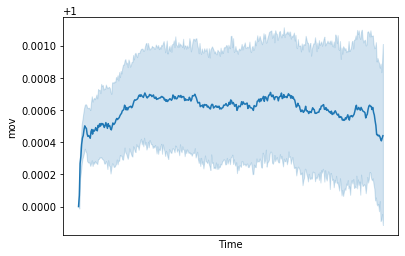

In [9]:
ax = sns.lineplot(x="Time", y="mov", data=norm_df, ci=99)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

c:\users\vilieri.i\onedri~1\tikit\my_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\vilieri.i\onedri~1\tikit\my_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


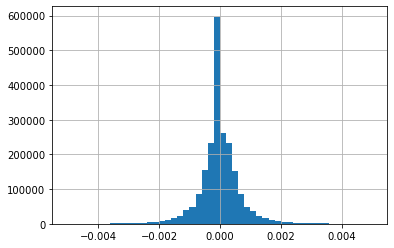

In [10]:
df['lag'] = df['Open'].shift(1)
df['return'] = df['Open'] / df['lag'] - 1.0
df[(df['return'] > -0.005) & (df['return'] < 0.005)]['return'].hist(bins=50)

In [11]:
len(df[df['return']==0.0])/len(df)*100

15.772516081750023

# Modeling

In [12]:
import xgboost as xgb
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

## Feature Engineering

In [13]:
def feature_engineering(df, descriptives, lags, returns, indicators, drop_corr=False, pca=False):
    '''
    Generates df with new features
    Parameters:
        df           : time serie dataframe
        descriptives : list with frequencies for descriptive analytics
        lags         : list with frequencies for lags
        returns      : list with frequencies for returns
        indicators   : list with frequencies for indicators
    '''
    xgb_df = df[['Date','Time','Open']]
    xgb_df = xgb_df.set_index(['Date','Time'])
    xgb_df['return_1'] = np.log(xgb_df.Open) - np.log(xgb_df.Open.shift(1)) 
    
    # Cast descriptives
    for d in descriptives:
        xgb_df['_'.join([str(d),'mean'])] = xgb_df.return_1.rolling(d).mean()
        xgb_df['_'.join([str(d),'std'])] = xgb_df.return_1.rolling(d).std()
        xgb_df['_'.join([str(d),'max'])] = xgb_df.return_1.rolling(d).max()
        xgb_df['_'.join([str(d),'min'])] = xgb_df.return_1.rolling(d).min()
        xgb_df['_'.join([str(d),'median'])] = xgb_df.return_1.rolling(d).median()
    
    # Cast lags
    for l in lags:
        xgb_df['_'.join(['lag', str(l)])] = xgb_df.return_1.shift(l)
    
    # Cast returns
    for r in returns:
        xgb_df['_'.join(['return', str(r)])] = xgb_df.Open / xgb_df.Open.shift(r) - 1.0
        xgb_df['_'.join([str(d),'mean_return'])] = xgb_df['_'.join(['return', str(r)])].rolling(d).mean()
        xgb_df['_'.join([str(d),'std_return_return'])] = xgb_df['_'.join(['return', str(r)])].rolling(d).std()
        xgb_df['_'.join([str(d),'max_return'])] = xgb_df['_'.join(['return', str(r)])].rolling(d).max()
        xgb_df['_'.join([str(d),'min_return'])] = xgb_df['_'.join(['return', str(r)])].rolling(d).min()
        xgb_df['_'.join([str(d),'median_return'])] = xgb_df['_'.join(['return', str(r)])].rolling(d).median()
        
    xgb_df['cummean'] = xgb_df['return_1'].expanding().mean()
    xgb_df['cumstd'] = xgb_df['return_1'].expanding().std()
    xgb_df['cummax'] = xgb_df['return_1'].expanding().max()
    xgb_df['cummin'] = xgb_df['return_1'].expanding().min()
    xgb_df['cummedian'] = xgb_df['return_1'].expanding().median()
    
    # Cast indicators
    xgb_df['indicator_up'] = np.where(xgb_df.return_1 > 0,1,0)
    xgb_df['indicator_down'] = np.where(xgb_df.return_1 < 0,1,0)
    
    for i in indicators:
        xgb_df['_'.join([str(i),'count_ups'])] = xgb_df.indicator_up.rolling(i).sum()
        xgb_df['_'.join([str(i),'count_downs'])] = xgb_df.indicator_down.rolling(i).sum()
    
    # Cast time
    xgb_df['time_00'] = np.where(xgb_df.index.get_level_values('Time').str.endswith('00'),1,0)
    xgb_df['time_15'] = np.where(xgb_df.index.get_level_values('Time').str.endswith('15'),1,0)
    xgb_df['time_30'] = np.where(xgb_df.index.get_level_values('Time').str.endswith('30'),1,0)
    xgb_df['time_45'] = np.where(xgb_df.index.get_level_values('Time').str.endswith('45'),1,0)
    xgb_df['first_quote'] = np.where(xgb_df.index.get_level_values('Time').str.contains('09:30'),1,0)
    xgb_df['last_quote'] = np.where(xgb_df.index.get_level_values('Time').str.contains('15:59'),1,0)
    xgb_df['last_quotes'] = np.where(xgb_df.index.get_level_values('Time').str.contains('15:5'),1,0)
    xgb_df['mid_quotes'] = np.where(xgb_df.index.get_level_values('Time').str.contains('12:'),1,0)
    
    if drop_corr:
        corr_matrix = xgb_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        xgb_df.drop(xgb_df[to_drop], axis=1, inplace=True)
    
    if pca:
        pipe = Pipeline([('scaler', StandardScaler()),
                         ('reducer', PCA(n_components=0.9))])
        xgb_df = pipe.fit_transform(xgb_df)
        
    # Cast target
    xgb_df['y'] = xgb_df.return_1.shift(-1)
    
    xgb_df.dropna(inplace=True)
    
    return xgb_df

In [14]:
def feature_engineering_split(df):
    '''
    Augments df with new features after splitting to avoid data leakage.
    Parameters:
        df : time serie dataframe after first feature engineering
    '''
    # Cast decomposition
    d = df
    format = '%Y-%m-%d %H:%M:%S'
    d['Datetime'] = pd.to_datetime(d['Date'].astype(str) + ' ' + d['Time'].astype(str), format=format)
    d = d.set_index(pd.DatetimeIndex(d['Datetime']))
    d = d.drop(['Date','Time','Datetime'], axis=1)
    seasonal_decompose(d.Open, model='additive', period=391*365)
    result.trend
    result.seasonal
    result.resid
    
    # Cast entropy
    pA = A / A.sum()
    Shannon2 = -np.sum(pA*np.log2(A))
    
    # Cast minute descriptives
    # use onehotencoder
    
    return 'On development'

In [15]:
list_descriptives = [5, 15, 30, 45, 60, 90, 120, 390, 780]
list_lags = [*range(1,781)]
list_returns = [5, 15, 30, 45, 60, 90, 120, 390, 780]
list_indicators = [2, 3, 4, 5, 15, 30, 45, 60, 90, 120, 390, 780]

xgb_df = feature_engineering(df, list_descriptives, list_lags, list_returns, list_indicators)

# Train and Test split

In [344]:
X = xgb_df.tail(100_000).loc[:, xgb_df.columns != 'y']
y = xgb_df.tail(100_000).loc[:, xgb_df.columns == 'y']

In [345]:
train_size = len(X)*95//100
valid_size = len(X)*99//100

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:valid_size], y[train_size:valid_size]
X_test, y_test = X[valid_size:], y[valid_size:]

print(f'Train set dim: {X_train.shape}')
print(f'Valid set dim: {X_valid.shape}')
print(f'Test set dim: {X_test.shape}')

Train set dim: (95000, 880)
Valid set dim: (4000, 880)
Test set dim: (1000, 880)


# ADF

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
print("p-value:", adfuller(X_train.return_1)[1])

p-value: 0.0


# Naive Forecasting

In [235]:
# Naive forecasting
y_pred = X_test.return_1
naive_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Naive lag model RMSE: {naive_rmse}')

Naive lag model RMSE: 0.00054824642857509


In [290]:
# Naive mean forecasting
y_pred = np.array([np.mean(X_train.return_1)]*len(X_test))
naivem_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Naive mean model RMSE: {naivem_rmse}')

Naive mean model RMSE: 0.00038233876623438337


## XGBoost

In [347]:
n_iter_pct = 0.20

params = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'max_depth': range(2, 5),
    'gamma': [0],
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

grid_size = len(params['learning_rate']) * \
            len(params['max_depth']) * \
            len(params['gamma']) * \
            len(params['colsample_bytree']) * \
            len(params['subsample'])
            
iter_search = int(grid_size * n_iter_pct)

print(f'Total Parameters space: {grid_size}')
print(f'Max parameter config to sample: {iter_search} ({n_iter_pct*100} %)')

Total Parameters space: 720
Max parameter config to sample: 144 (20.0 %)


In [33]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', n_estimators=500, 
                             silent=True, verbose=True)

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=10)

# Perform random search: grid_mse
xgb_rcv_model = RandomizedSearchCV(estimator=xgb_model, scoring='neg_mean_squared_error', 
                                   cv=tscv, n_iter=iter_search, param_distributions=params, refit=True, n_jobs=-1, 
                                   random_state=42, verbose=10)

xgb_rcv_model.fit(X_train.tail(10_000), y_train.tail(10_000))

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 79.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 136.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 162.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 194.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 228.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 282.0min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 346.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 346.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                   error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=500,
                                          n_jobs=-1, nthread=None,...
                   iid='deprecated', n_iter=14, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0],
                                        'le

In [72]:
# Fine tuning using early stopping
DM_train = xgb.DMatrix(X_train, y_train)
DM_valid = xgb.DMatrix(X_valid, y_valid)

watchlist = [(DM_train, 'train'), (DM_valid, 'valid')]

# Get best parameters
best_params = {**xgb_rcv_model.best_params_, **{'booster':'gbtree', 'objective':'reg:squarederror'}}

# Train to get the feature importances
xgb_reg = xgb.train(best_params, DM_train, 1000, watchlist, verbose_eval=10, early_stopping_rounds=50)

[0]	train-rmse:0.459884	valid-rmse:0.460001
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.199839	valid-rmse:0.199821
[20]	train-rmse:0.086797	valid-rmse:0.086801
[30]	train-rmse:0.03771	valid-rmse:0.03771
[40]	train-rmse:0.016391	valid-rmse:0.016392
[50]	train-rmse:0.007142	valid-rmse:0.007146
[60]	train-rmse:0.003154	valid-rmse:0.003163
[70]	train-rmse:0.001483	valid-rmse:0.001504
[80]	train-rmse:0.000856	valid-rmse:0.000894
[90]	train-rmse:0.000674	valid-rmse:0.000726
[100]	train-rmse:0.000632	valid-rmse:0.000692
[110]	train-rmse:0.000622	valid-rmse:0.000686
[120]	train-rmse:0.000619	valid-rmse:0.000684
[130]	train-rmse:0.000616	valid-rmse:0.000684
[140]	train-rmse:0.000615	valid-rmse:0.000684
[150]	train-rmse:0.000613	valid-rmse:0.000685
[160]	train-rmse:0.000611	valid-rmse:0.000685
[170]	train-rmse:0.000609	valid-rmse:0.000686
Stopping. Best iteration:
[123]	train-rm

In [83]:
DM_test = xgb.DMatrix(X_test, y_test)

y_pred = xgb_reg.predict(DM_test)
xgb_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'XGBoost model RMSE: {xgb_rmse}')

XGBoost model RMSE: 0.00038112460965646956


### XGBoost predictions

In [87]:
print(f'XGBoost vs baseline: {round(xgb_rmse/naive_rmse - 1, 2)*100}%')
print(f'XGBoost vs mean baseline: {round(xgb_rmse/naivem_rmse - 1, 3)*100}%')

XGBoost vs baseline: -30.0%
XGBoost vs mean baseline: -0.3%


In [73]:
# Save to disk
filename = 'output/xgb_rcv_model.joblib.pkl'
_ = joblib.dump(xgb_rcv_model, filename, compress=9)

filename = 'output/xgb_reg_model.joblib.pkl'
_ = joblib.dump(xgb_reg, filename, compress=9)

In [82]:
# Load model
xgb_reg = joblib.load('output/xgb_reg_model.joblib.pkl')

## Feature importance

In [41]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, **kwargs)

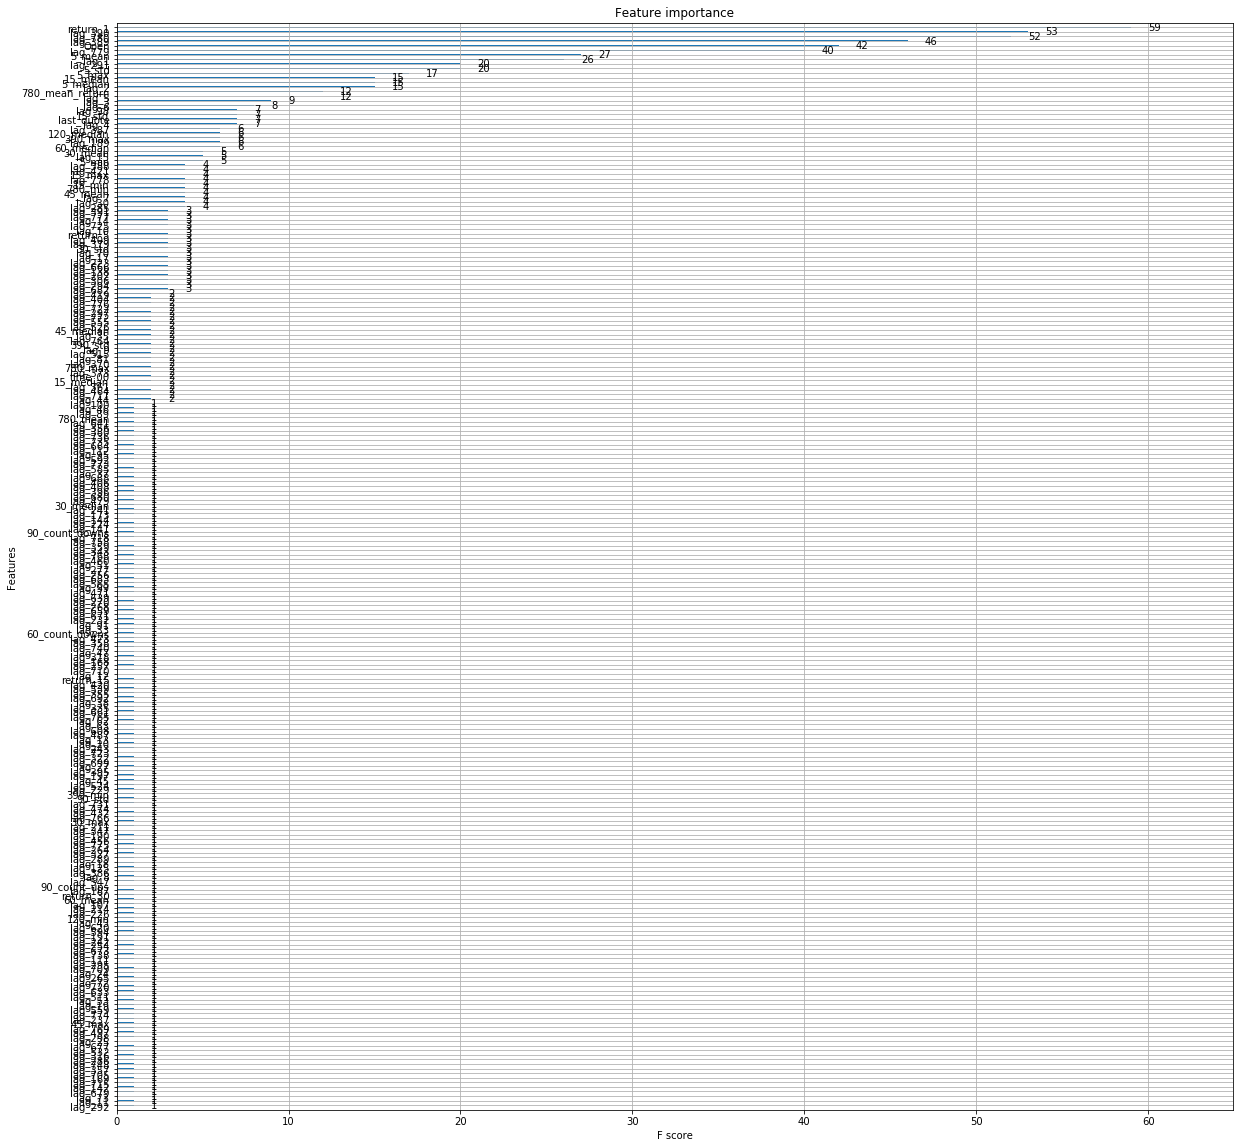

In [43]:
my_plot_importance(xg_reg, [20,20])

# Fractional Differencing

In [129]:
def getWeights(d,lags):
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot()
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()

def ts_differencing(series, order, lag_cutoff):
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

def plotMemoryVsCorr(result, seriesName):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()  
    color1='xkcd:deep red'; color2='xkcd:cornflower blue'
    ax.plot(result.order,result['adf'],color=color1)
    ax.plot(result.order, result['p-value'], color='xkcd:slate')
    ax2.plot(result.order,result['corr'], color=color2)
    ax.set_xlabel('order of differencing')
    ax.set_ylabel('adf', color=color1);ax.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylabel('corr', color=color2); ax2.tick_params(axis='y', labelcolor=color2)
    plt.title('ADF test statistics and correlation for %s' % (seriesName))
    plt.show()

def frac_diff(series, dRange, numberPlots, lag_cutoff, seriesName, plot=False):
    interval=np.linspace(dRange[0], dRange[1], numberPlots)
    result=pd.DataFrame(np.zeros((len(interval),4)))
    result.columns = ['order','adf','corr', 'p-value']
    result['order']=interval
    for counter,order in enumerate(interval):
        seq_traf=ts_differencing(series,order,lag_cutoff)
        res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
        result.loc[counter,'adf']=res[0]
        result.loc[counter,'p-value']=res[1]
        result.loc[counter,'corr']= np.corrcoef(series[lag_cutoff:].fillna(0),seq_traf)[0,1]
    if plot:
        plotMemoryVsCorr(result, seriesName)    
    return result

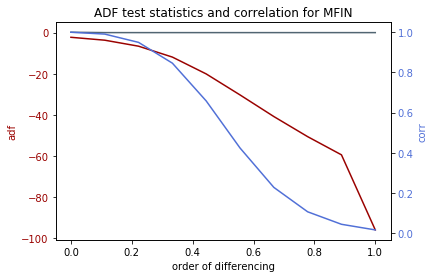

,order,adf,corr,p-value
0,0.000000,-2.275011,1.000000,1.801542e-01
1,0.111111,-3.685869,0.990833,4.316364e-03
2,0.222222,-6.603588,0.949535,6.641639e-09
3,0.333333,-11.902557,0.846060,5.531275e-22
4,0.444444,-20.089834,0.657919,0.000000e+00
5,0.555556,-30.304390,0.423705,0.000000e+00
6,0.666667,-40.820393,0.227453,0.000000e+00
7,0.777778,-50.605354,0.105891,0.000000e+00
8,0.888889,-59.449915,0.043686,0.000000e+00
9,1.000000,-95.968189,0.015665,0.000000e+00


In [132]:
frac_diff(X_train.Open, [0,1], 10, 390, 'MFIN', plot=True)

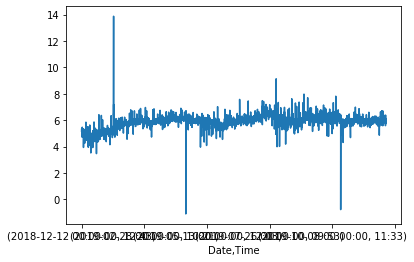

In [93]:
ts_differencing(X_train.Open, 0.444, 390).plot()

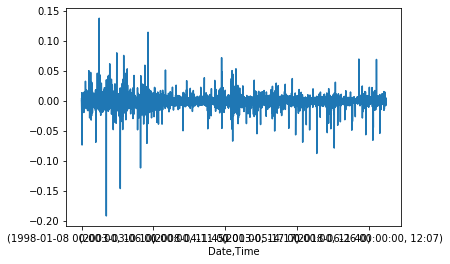

In [101]:
X_train.return_1.plot()

# ARIMA

In [54]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA

In [55]:
warnings.filterwarnings("ignore")

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions, squared=False)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.10f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.10f' % (best_cfg, best_score))
    
def evaluate_arima_final_model(X, y, arima_order):
    # prepare training dataset
    train, test = X, y
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions, squared=False)
    print('ARIMA RMSE=%.10f' % (error))
    return error

In [107]:
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(X_train.return_1.tail(390*2), p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.0003362546
ARIMA(0, 0, 1) RMSE=0.0003358710
ARIMA(0, 0, 2) RMSE=0.0003363668
ARIMA(0, 1, 0) RMSE=0.0004930706
ARIMA(0, 1, 1) RMSE=0.0003411620
ARIMA(0, 1, 2) RMSE=0.0003415548
ARIMA(0, 2, 0) RMSE=0.0008633623
ARIMA(0, 2, 1) RMSE=0.0004939171
ARIMA(0, 2, 2) RMSE=0.0003732732
ARIMA(1, 0, 0) RMSE=0.0003361253
ARIMA(1, 0, 1) RMSE=0.0003373472
ARIMA(1, 1, 0) RMSE=0.0004286692
ARIMA(1, 1, 1) RMSE=0.0003432446
ARIMA(1, 1, 2) RMSE=0.0003422924
ARIMA(1, 2, 0) RMSE=0.0006672139
ARIMA(2, 0, 0) RMSE=0.0003363478
ARIMA(2, 1, 0) RMSE=0.0003832245
ARIMA(2, 1, 1) RMSE=0.0003492104
ARIMA(2, 1, 2) RMSE=0.0003403109
ARIMA(2, 2, 0) RMSE=0.0005374880
Best ARIMA(0, 0, 1) MSE=0.0003358710


In [108]:
arima_order = (0, 0, 1)
arima_rmse = evaluate_arima_final_model(X_valid.return_1.tail(390*2), y_test.y, arima_order)

ARIMA RMSE=0.0003848083


In [351]:
print(f'ARIMA vs baseline: {round(arima_rmse/naive_rmse - 1, 4)*100}%')
print(f'ARIMA vs mean baseline: {round(arima_rmse/naivem_rmse - 1, 3)*100}%')

ARIMA vs baseline: -29.81%
ARIMA vs mean baseline: 0.6%


# GARCH Models

In [353]:
import arch

X_train_garch = X_train.append(X_valid)
X_train_garch = 100 * X_train_garch.return_1

In [111]:
def get_best_arima(ts):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5)
    d_rng = range(2)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = ARIMA(ts, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order)) 
    return best_aic, best_order, best_mdl

In [354]:
res_tup = get_best_arima(X_train_garch)

aic: -246167.14 | order: (4, 0, 0)


In [373]:
am = arch.arch_model(X_train_garch, p=4, q=0, o=1, power=2.0, vol='Garch', dist='StudentsT')
res = am.fit(disp='off')
print(res.summary())

c:\users\vilieri.i\onedri~1\tikit\my_env\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     return_1   R-squared:               -41593549.786
Mean Model:                   Constant Mean   Adj. R-squared:          -41593549.786
Vol Model:                        GJR-GARCH   Log-Likelihood:           -3.48741e+06
Distribution:      Standardized Student's t   AIC:                       6.97484e+06
Method:                  Maximum Likelihood   BIC:                       6.97491e+06
                                              No. Observations:                99000
Date:                      Thu, Mar 19 2020   Df Residuals:                    98992
Time:                              13:12:38   Df Model:                            8
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [357]:
forecasts = res.forecast(horizon=X_test.shape[0])

In [399]:
mu = np.mean(X_train_garch) / 100

y_pred = []

for var in forecasts.variance.dropna().T.values:
    sigma = np.sqrt(var)
    value = np.random.normal(mu, sigma, 1)
    y_pred.append(value/100**3)

In [400]:
garch_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'GARCH model RMSE: {garch_rmse}')

GARCH model RMSE: 0.0004037476375064676


In [403]:
print(f'GARCH vs baseline: {round(garch_rmse/naive_rmse - 1, 2)*100}%')
print(f'GARCH vs mean baseline: {round(garch_rmse/naivem_rmse - 1, 2)*100}%')

GARCH vs baseline: -26.0%
GARCH vs mean baseline: 6.0%


# Recurrent Neural Networks

In [205]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [134]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [135]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [136]:
train_size = len(X)*95//100
valid_size = len(X)*99//100

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:valid_size], y[train_size:valid_size]
X_test, y_test = X[valid_size:], y[valid_size:]

print(f'Train set dim: {X_train.shape}')
print(f'Valid set dim: {X_valid.shape}')
print(f'Test set dim: {X_test.shape}')

Train set dim: (95000, 880)
Valid set dim: (4000, 880)
Test set dim: (1000, 880)


In [337]:
scaler = MinMaxScaler()
scaler.fit(X_train)

float_data = pd.DataFrame(scaler.transform(X), columns = X_train.columns)
float_data = float_data.values.astype(np.float32)

In [311]:
lookback = 1                 # How many timesteps back the input data should go.
step = 1                      # The period, in timesteps, at which you sample data.
delay = 0                     # How many timesteps in the future the target should be.
batch_size = 32               # The number of samples per batch.

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train_size,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_size+1,
                    max_index=valid_size,
                    step=step,
                    batch_size=batch_size)

val_steps = (valid_size - train_size + 1 - lookback) // batch_size

In [312]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     return_sequences=True,
                     recurrent_dropout=0.5))
model.add(layers.GRU(128, 
                     activation='relu',
                     dropout=0.1,
                     return_sequences=True,
                     recurrent_dropout=0.5))
model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     return_sequences=True,
                     recurrent_dropout=0.5))
model.add(layers.GRU(32, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

optimizer = keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
model.compile(optimizer=optimizer, loss=root_mean_squared_error)

In [313]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, None, 32)          87744     
_________________________________________________________________
gru_32 (GRU)                 (None, None, 64)          18816     
_________________________________________________________________
gru_33 (GRU)                 (None, None, 128)         74496     
_________________________________________________________________
gru_34 (GRU)                 (None, None, 64)          37248     
_________________________________________________________________
gru_35 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 227,745
Trainable params: 227,745
Non-trainable params: 0
_______________________________________________

In [324]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = ModelCheckpoint('gru_rnn.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                             callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/5
499/500 [============================>.] - ETA: 4s - loss: 0.0039
Epoch 00001: val_loss improved from inf to 0.02186, saving model to gru_rnn.h5
500/500 [==============================] - 2186s 4s/step - loss: 0.0039 - val_loss: 0.0219
Epoch 2/5
499/500 [============================>.] - ETA: 3s - loss: 0.0046
Epoch 00002: val_loss did not improve from 0.02186
500/500 [==============================] - 2113s 4s/step - loss: 0.0046 - val_loss: 0.0223
Epoch 3/5
499/500 [============================>.] - ETA: 3s - loss: 0.0041
Epoch 00003: val_loss improved from 0.02186 to 0.02109, saving model to gru_rnn.h5
500/500 [==============================] - 2032s 4s/step - loss: 0.0041 - val_loss: 0.0211
Epoch 4/5
499/500 [============================>.] - ETA: 3s - loss: 0.0055
Epoch 00004: val_loss did not improve from 0.02109
500/500 [==============================] - 2194s 4s/step - loss: 0.0055 - val_loss: 0.0214
Epoch 5/5
499/500 [============================>.] - ETA: 4s - loss:

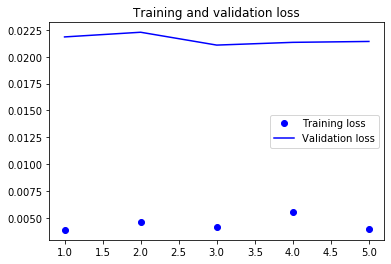

In [325]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [331]:
model = load_model('models/gru_rnn.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [332]:
float_data = pd.DataFrame(scaler.transform(X), columns = X_train.columns)
data_test = float_data.values.astype(np.float32)
test_gen = generator(data_test,
                    lookback=lookback,
                    delay=delay,
                    min_index=99000 - lookback - delay,
                    max_index=None,
                    step=step,
                    batch_size=1)

In [333]:
preds_scaled = model.predict_generator(test_gen, steps=X_test.shape[0])
preds_scaled.shape

(1000, 1)

In [334]:
preds_scaled_df = np.zeros((X_test.shape[0],880))
preds_scaled_df[:,1] = preds_scaled[:,0]
preds = scaler.inverse_transform(preds_scaled_df)[:, [1]]

In [335]:
rnn_rmse = mean_squared_error(y_test, preds, squared=False)
print(f'RNN model RMSE: {rnn_rmse}')

RNN model RMSE: 0.015556500075275714


In [336]:
print(f'RNN vs baseline: {round(rnn_rmse/naive_rmse - 1, 2)*100}%')
print(f'RNN vs mean baseline: {round(rnn_rmse/naivem_rmse - 1, 3)*100}%')

RNN vs baseline: 2738.0%
RNN vs mean baseline: 3968.8%


## WAVENET

In [411]:
train_size = len(X)*95//100
valid_size = len(X)*99//100

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:valid_size], y[train_size:valid_size]
X_test, y_test = X[valid_size:], y[valid_size:]

print(f'Train set dim: {X_train.shape}')
print(f'Valid set dim: {X_valid.shape}')
print(f'Test set dim: {X_test.shape}')

Train set dim: (1942418, 880)
Valid set dim: (200000, 880)
Test set dim: (1000, 880)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

float_data = pd.DataFrame(scaler.transform(X), columns = X_train.columns)
float_data = float_data.values.astype(np.float32)

In [264]:
lookback = 1                  # How many timesteps back the input data should go.
step = 1                      # The period, in timesteps, at which you sample data.
delay = 0                     # How many timesteps in the future the target should be.
batch_size = 32               # The number of samples per batch.

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train_size,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_size+1,
                    max_index=valid_size,
                    step=step,
                    batch_size=batch_size)

val_steps = (valid_size - train_size + 1 - lookback) // batch_size

In [291]:
model = Sequential()
model.add(layers.InputLayer(input_shape=(None, float_data.shape[-1])))
for rate in (1, 2, 4, 8, 16) * 2:
    model.add(layers.Conv1D(filters=20, kernel_size=1, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(layers.Conv1D(filters=1, kernel_size=1))

model.compile(optimizer=optimizer, loss=root_mean_squared_error)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, None, 20)          17620     
_________________________________________________________________
conv1d_137 (Conv1D)          (None, None, 20)          420       
_________________________________________________________________
conv1d_138 (Conv1D)          (None, None, 20)          420       
_________________________________________________________________
conv1d_139 (Conv1D)          (None, None, 20)          420       
_________________________________________________________________
conv1d_140 (Conv1D)          (None, None, 20)          420       
_________________________________________________________________
conv1d_141 (Conv1D)          (None, None, 20)          420       
_________________________________________________________________
conv1d_142 (Conv1D)          (None, None, 20)         

In [266]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = ModelCheckpoint('wavenet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/50
499/500 [============================>.] - ETA: 0s - loss: 0.1020
Epoch 00001: val_loss improved from inf to 0.01961, saving model to wavenet.h5
500/500 [==============================] - 66s 131ms/step - loss: 0.1018 - val_loss: 0.0196
Epoch 2/50
499/500 [============================>.] - ETA: 0s - loss: 0.0211
Epoch 00002: val_loss did not improve from 0.01961
500/500 [==============================] - 75s 150ms/step - loss: 0.0211 - val_loss: 0.0268
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 00003: val_loss did not improve from 0.01961
500/500 [==============================] - 72s 144ms/step - loss: 0.0143 - val_loss: 0.0239
Epoch 4/50
499/500 [============================>.] - ETA: 0s - loss: 0.0101- ETA: 1s - loss: 
Epoch 00004: val_loss did not improve from 0.01961
500/500 [==============================] - 91s 182ms/step - loss: 0.0102 - val_loss: 0.0242
Epoch 5/50
499/500 [============================>.] - ETA: 0s - loss: 0.00

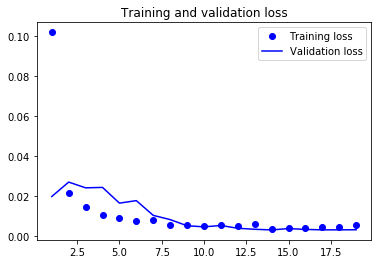

In [267]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [268]:
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=99000 - lookback - delay,
                    max_index=None,
                    step=step,
                    batch_size=1)

In [414]:
model = load_model('models/wavenet.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [340]:
preds_scaled = model.predict_generator(test_gen, steps=X_test.shape[0])
preds_scaled.shape

(1000, 10, 1)

In [341]:
preds_scaled_df = np.zeros((X_test.shape[0],880))
preds_scaled_df[:,1] = preds_scaled[:,0][:,0]
preds = scaler.inverse_transform(preds_scaled_df)[:, [1]]

In [342]:
wn_rmse = mean_squared_error(y_test, preds, squared=False)
print(f'Wavenet model RMSE: {wn_rmse}')

RNN model RMSE: 0.0003831683999630453


In [343]:
print(f'Wavenet vs baseline: {round(wn_rmse/naive_rmse - 1, 2)*100}%')
print(f'Wavenet vs mean baseline: {round(wn_rmse/naivem_rmse - 1, 2)*100}%')

RNN vs baseline: -30.0%
RNN vs mean baseline: 0.0%
